In [1]:
import numpy as np
import dadi


In [2]:
fs = dadi.Spectrum.from_file('/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/dadi_2D/anopheles-rose.3.unifiedGenotyper.cov14x.passQC.merge.pol.LPdom_LBVwil.fs')


Text(0.5, 1.0, 'Orignal data')

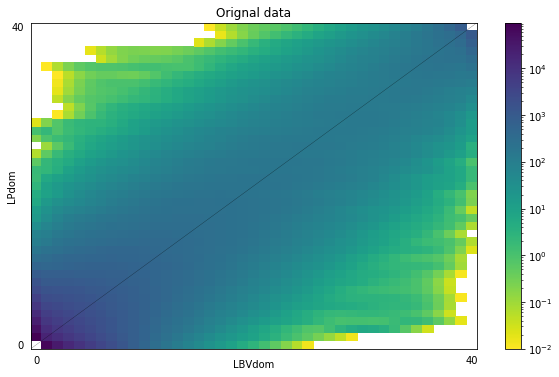

In [3]:
# Plot comparing the multiple versions of our data spectra.
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize=(10,6))
fig.clear()

ax = fig.add_subplot(1,1,1)
dadi.Plotting.plot_single_2d_sfs(fs, vmin=1e-2, ax=ax)
ax.set_title('Orignal data')


In [4]:
# model
def SCG(params, ns, pts):
    n1,n2 = ns
    nu1, nu2, b1, b2, m12, m21, Ts, Tsc, O = params
   
    """
    Model with split, complete isolation, followed by secondary contact with exponential growth

    nu1: Size of population 1 at split.
    nu2: Size of population 2 at split.
    b1: Population growth coefficient of population 1
    b2: Population growth coefficient of population 2
    m12: Migration from pop 2 to pop 1 (2*Na*m12).
    m21: Migration from pop 1 to pop 2.
    Ts: The scaled time between the split and the secondary contact (in units of 2*Na generations).
    Tsc: The scale time between the secondary contact and present.
    O: The proportion of accurate orientation
    n1,n2: Size of fs to generate.
    pts: Number of points to use in grid for evaluation.
    """
    
    # Define the grid we'll use
    xx = dadi.Numerics.default_grid(pts)

    # phi for the equilibrium ancestral population
    phi = dadi.PhiManip.phi_1D(xx)
    # Now do the divergence event
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)
    # We set the population sizes after the split to nu1 and nu2 and the migration rate to zero
    phi = dadi.Integration.two_pops(phi, xx, Ts, nu1, nu2, m12=0, m21=0)
    # We start the population reduction after the split and set the migration rates to m12 and m21
    bnu1_func = lambda t: nu1 * b1**(t/Tsc)
    bnu2_func = lambda t: nu2 * b2**(t/Tsc)
    phi = dadi.Integration.two_pops(phi, xx, Tsc, bnu1_func, bnu2_func, m12=m12, m21=m21)
    ###
    ## Calculate the spectrum
    # Oriented
    fsO = dadi.Spectrum.from_phi(phi, (n1,n2), (xx,xx))
    # Mis-oriented
    fsM = dadi.Numerics.reverse_array(fsO)
    
    # calculate the spectrum.
    fs = O*fsO+(1-O)*fsM
    return fs


In [5]:
pts_l = [50,60,70]
func = SCG
func_ex = dadi.Numerics.make_extrap_log_func(func)

#     nu1, nu2, b1, b2, m12, m21, Ts, Tsc, O = params
popt = [6.078434, 2.054769, 0.1005408, 0.308346, 8.259579, 4.676862, 0.2975986, 0.1729786, 0.9886787]


In [8]:
# Estimate parameter uncertainties using the Godambe Information Matrix, to
# account for linkage in the data. 
import dadi.Godambe


In [9]:
all_boot = [dadi.Spectrum.from_file('/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/dadi_2D/LPdom_LBVwil_dadi_bootstrap/anopheles-rose.3.unifiedGenotyper.cov14x.passQC.merge.pol.LPdom_LBVwil.nomiss.LPdom_LBVdom.fs.boot_{0}'.format(i)) for i in range(1000)]

In [10]:
uncerts, GIM = dadi.Godambe.GIM_uncert(func_ex, pts_l, all_boot, popt, fs, multinom=True, return_GIM = True)

In [11]:
print('Estimated parameter standard deviations from GIM: {0}'.format(uncerts))


Estimated parameter standard deviations from GIM: [9.31919869e-01 2.79958976e-01 1.14452344e-02 5.94743686e-02
 1.29838950e+00 8.23823258e-01 4.37477503e-02 7.57683549e-02
 7.40859765e-03 6.75724102e+03]


In [13]:
print(GIM.shape)

(10, 10)
